Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Palco 2010

## Overview

Palco 2010 presents no interactions in months 6, 7, 8 and 9.  
Consequently, the third quarter presents almost no interactions.  
Moreover, first and last quarters contain most interactions.  
When divided by two semesters, the first semester presents almost twice the interactions of the second.  

109 users of 7580 (1.438%) occurr in 80.0% or more months.  
0 users of 7580 (0.0%) occurr in 80.0% or more quarters.  
1102 users of 7580 (14.538%) occurr in 80.0% or more semesters.  
___ 

When divided in buckets of same size, number of users per bucket is between 1k and 2k.  
147 users of 7580 (1.939%) occur in 80.0% or more buckets.  
There are at least 100 frequent users in each bucket. Their number of interactions reduces with time.  
Buckets present interactions from at most 2 months, with the exception of bucket 9, which presents interactions from months 5, 10, and 11.

## Reading data

In [3]:
# importa dataset 'palco playlists'
data = pd.read_csv("../datasets/palco_2010.tsv","\t")
dataset_name = 'Palco2010'

user_col = 'user_id'
item_col = 'track_id'

In [4]:
# Necessary Preprocess - create date from timestamp
data['date2'] = data['timestamp'].apply(lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d') )
data['year'] = data['date2'].dt.year
data['month'] = data['date2'].dt.month
data['date'] = data[['year', 'month']].apply(lambda x: datetime.strptime( str(x[0])+'/'+str(x[1]), '%Y/%m' ) , axis=1)

## Evaluating Time defined Buckets 

How many interactions occur in each month?

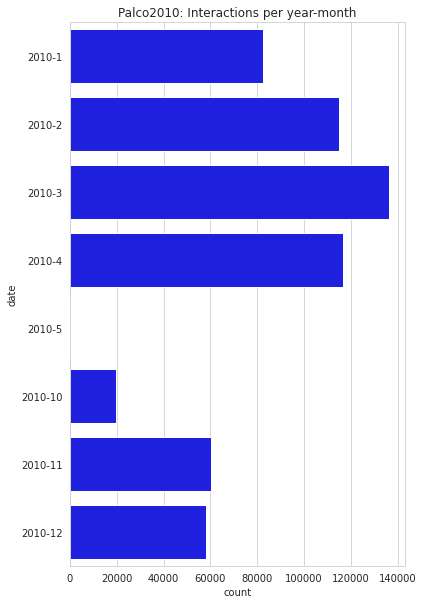

In [5]:
plot_interactions_per_month(data=data, dataset_name='Palco2010')

In [6]:
data['user_id'].value_counts() >= 5

53        True
38832     True
48802     True
95        True
1151      True
         ...  
6539     False
50064    False
47006    False
13883    False
44869    False
Name: user_id, Length: 7580, dtype: bool

In [7]:
k_core_users = data['user_id'].value_counts()[ data['user_id'].value_counts() >= 5 ].index

In [8]:
data = data.set_index('user_id').loc[k_core_users].reset_index()

In [9]:
data.shape

(584327, 7)

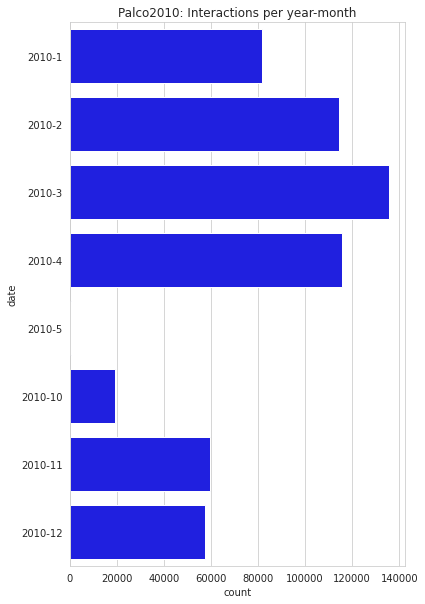

In [10]:
plot_interactions_per_month(data=data, dataset_name=dataset_name)

In [11]:
# y_filter = (data['date'] < datetime.strptime('2018', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 
# y_filter = (data['date'] < datetime.strptime('2015-01', '%Y-%m')) & (datetime.strptime('2014-01', '%Y-%m') <= data['date']) 
y_filter = (data['date2'] < datetime.strptime('2010-05', '%Y-%m')) & (datetime.strptime('2010-01', '%Y-%m') <= data['date']) 

In [12]:
y_filter.sum()

447380

In [13]:
data = data[y_filter.tolist()]

In [14]:
# number of remaining cases
data.shape[0]

447380

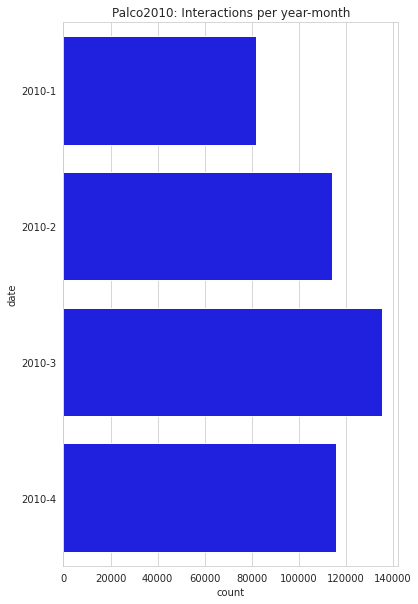

In [15]:
plot_interactions_per_month(data=data, dataset_name=dataset_name)

Sampling the dataset - only most frequent users (overall)

In [16]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months = data.groupby(by=['user_id'])['date'].nunique()

CPU times: user 62 ms, sys: 2.64 ms, total: 64.7 ms
Wall time: 124 ms


<AxesSubplot:ylabel='Frequency'>

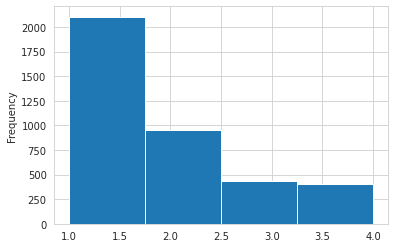

In [17]:
user_freq_over_months.plot(kind='hist',bins=user_freq_over_months.max())

In [18]:
_ = data.set_index('user_id').copy()

<AxesSubplot:>

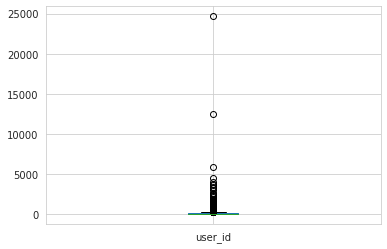

In [19]:
# frequency of users that occur every month:
_.reset_index()['user_id'].value_counts().plot(kind='box')

In [20]:
u = data['user_id'].value_counts().reset_index()['index'].to_list()

In [21]:
# to user, or not to use p ?
p = (data['user_id'].value_counts()/data['user_id'].shape[0])

In [22]:
prop = 0.75
s = round( len( u )*prop )

In [23]:
np.random.seed(42)
sampled_users = list( np.random.choice(u, size=s, replace=False, p=p) ) # , p=p

In [24]:
_.loc[sampled_users].shape

(435621, 6)

In [25]:
_.loc[sampled_users]['track_id'].nunique()

22103

<AxesSubplot:>

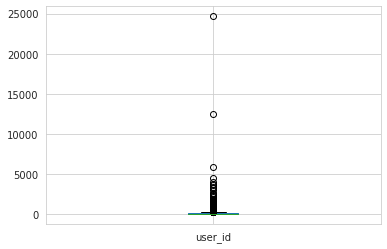

In [26]:
# frequency of users:
_.loc[sampled_users].reset_index()['user_id'].value_counts().plot(kind='box')

CPU times: user 320 ms, sys: 11.8 ms, total: 332 ms
Wall time: 440 ms


<AxesSubplot:ylabel='Frequency'>

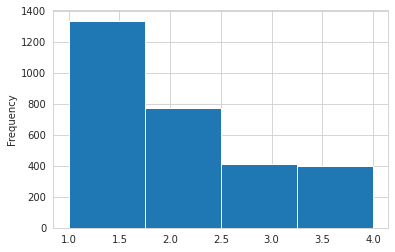

In [27]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months_sample = _.loc[sampled_users].reset_index().groupby(by=['user_id'])['date'].nunique()
user_freq_over_months_sample.plot(kind='hist',bins=user_freq_over_months_sample.max())

In [28]:
data['user_id'].nunique(), data['track_id'].nunique() # original number of users, original number of items

(3895, 22489)

In [29]:
# _.loc[freq_users].reset_index()['user_id'].nunique(), _.loc[freq_users].reset_index()['item_id'].nunique() # sample number of users, and of items
_.loc[sampled_users].reset_index()['user_id'].nunique(), _.loc[sampled_users].reset_index()['track_id'].nunique() # sample number of users, and of items

(2921, 22103)

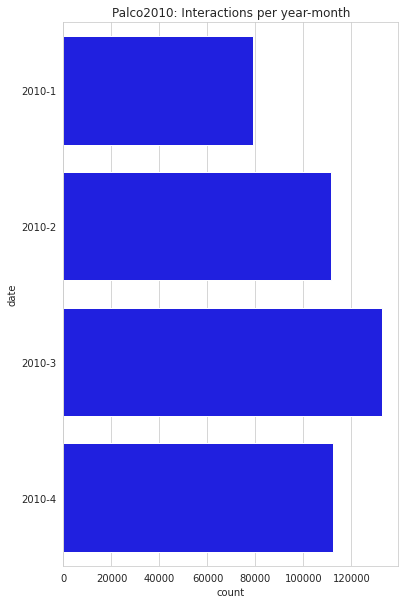

In [30]:
# %%time
# plot_interactions_per_month(data=_.loc[freq_users].reset_index(), dataset_name=dataset_name)
plot_interactions_per_month(data=_.loc[sampled_users].reset_index(), dataset_name=dataset_name)

In [31]:
USE_THRESHOLD = True
# all users 0.303427
# USING prop = 0.75 , .305128
# USING prop = 0.5, 0.315315

if USE_THRESHOLD: 
    data = _.loc[sampled_users].reset_index()
    data = data.sort_values(by=['timestamp', 'user_id', 'track_id'])
    print(data.shape[0])
else:
    print(data.shape[0])
# new sample
data.to_csv('output/palco_2010_dump/sampled_palco2010.csv', index=False)

435621


How many interactions occur in each month / year?

In [32]:
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: user 291 ms, sys: 2.94 ms, total: 294 ms
Wall time: 489 ms


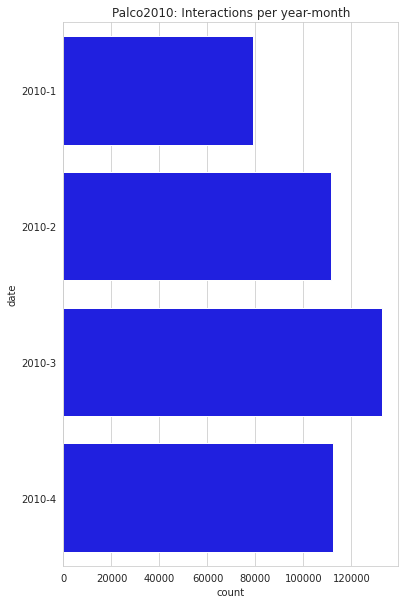

In [33]:
%%time
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [34]:
%%time
# 3min 16s
user_presence_df, user_month_interactions = get_interactions_info(data=data, user_col=user_col)

# new sample
user_presence_df.to_csv('output/palco_2010_dump/sample_user_presence_df.csv', index=False)
user_month_interactions.to_csv('output/palco_2010_dump/sample_user_month_interactions.csv', index=False)

0.0 %
CPU times: user 3.8 s, sys: 2.39 ms, total: 3.8 s
Wall time: 5.18 s


In [35]:
user_presence_df.head()

,UserID,month_%
0,170,1.0
1,39,1.0
2,8,1.0
3,20,1.0
4,1096,1.0


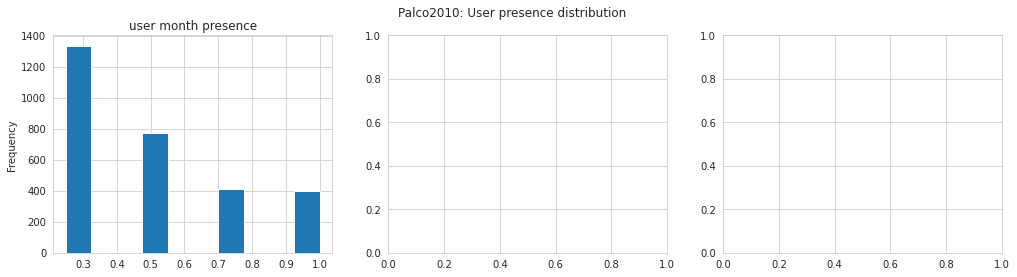

In [36]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

In [37]:
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')

In [38]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [39]:
# defining threshold
frequency_threshold = 1

In [40]:
# frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)
frequent_users_month = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

400 users of 2921 (13.694%) occurr in 100% or more months.


In [41]:
# old huge sample
# joblib.dump(frequent_users_month, 'output/amazonbooks_dump/frequent_users_month.joblib')

# new sample
joblib.dump(frequent_users_month, 'output/palco_2010_dump/sample_frequent_users_month.joblib')

['output/palco_2010_dump/sample_frequent_users_month.joblib']

___